<a href="https://colab.research.google.com/github/ridvanyigit/Machine_Learning/blob/main/ML_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Veri Seti Yükleme

#### Gerekli Kütüphanelerin İçe Aktarılması

In [1]:
import pandas as pd
import numpy as np
import requests
import gzip
import random
from io import StringIO
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier
import pickle
import warnings
warnings.filterwarnings('ignore')

#cuML Kutuphaneleri
import cuml
from cuml.svm import SVC
from cuml.metrics import roc_auc_score as roc_auc_score_gpu # GPU versiyonu

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Veri Seti Yükleme ve Örnekleme

In [3]:
# Veri seti URL'si
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz"

def reservoir_sampling_from_url(url, sample_size=50000):
    """
    Büyük veri setinden streaming olarak rastgele örneklem alır
    Reservoir Sampling algoritması kullanır
    """
    print(f"🔄 {sample_size:,} rastgele örneklem alınıyor...")
    print("⏳ Bu işlem birkaç dakika sürebilir...")

    response = requests.get(url, stream=True)
    response.raise_for_status()

    reservoir = []
    line_count = 0

    # Gzip dosyasını streaming olarak oku
    with gzip.open(response.raw, 'rt') as f:
        for line in f:
            line_count += 1
            line = line.strip()

            if len(reservoir) < sample_size:
                # Reservoir henüz dolmadı, direkt ekle
                reservoir.append(line)
            else:
                # Reservoir doldu, rastgele değiştir
                j = random.randint(0, line_count - 1)
                if j < sample_size:
                    reservoir[j] = line

            # İlerleme göstergesi
            if line_count % 500000 == 0:
                print(f"📊 İşlenen satır: {line_count:,}")

            if line_count >= 2000000:
                print("⚡ Hızlı test için 2M satırla sınırlandı")
                break

    print(f"✅ Toplam {line_count:,} satırdan {len(reservoir):,} örneklem alındı")
    return reservoir

sample_lines = reservoir_sampling_from_url(url, 50000)

🔄 50,000 rastgele örneklem alınıyor...
⏳ Bu işlem birkaç dakika sürebilir...
📊 İşlenen satır: 500,000
📊 İşlenen satır: 1,000,000
📊 İşlenen satır: 1,500,000
📊 İşlenen satır: 2,000,000
⚡ Hızlı test için 2M satırla sınırlandı
✅ Toplam 2,000,000 satırdan 50,000 örneklem alındı


#### DataFrame'e Dönüştürme

In [4]:
columns = ['label'] + [f'feature_{i}' for i in range(1, 29)]

print("🔄 Veri DataFrame'e dönüştürülüyor...")

# String verilerini DataFrame'e çevir
data_rows = []
for line in sample_lines:
    try:
        values = [float(x) for x in line.split(',')]
        if len(values) == 29:
            data_rows.append(values)
    except ValueError:
        continue

df = pd.DataFrame(data_rows, columns=columns)

print("✅ Veri hazırlandı!")
print(f"📊 Veri seti boyutu: {df.shape}")
print(f"💾 Bellek kullanımı: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Veri seti hakkında bilgi
print("📈 VERİ SETİ ÖZET BİLGİLERİ")
print("="*50)

print(f"Toplam satır sayısı: {len(df):,}")
print(f"Toplam sütun sayısı: {len(df.columns)}")

print(f"\n🎯 Hedef değişken (label) dağılımı:")
label_counts = df['label'].value_counts().sort_index()
for label, count in label_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  Label {int(label)}: {count:,} ({percentage:.1f}%)")

print(f"\n📊 İlk 5 satır:")
print(df.head())

🔄 Veri DataFrame'e dönüştürülüyor...
✅ Veri hazırlandı!
📊 Veri seti boyutu: (50000, 29)
💾 Bellek kullanımı: 11.06 MB
📈 VERİ SETİ ÖZET BİLGİLERİ
Toplam satır sayısı: 50,000
Toplam sütun sayısı: 29

🎯 Hedef değişken (label) dağılımı:
  Label 0: 23,683 (47.4%)
  Label 1: 26,317 (52.6%)

📊 İlk 5 satır:
   label  feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0    0.0   0.581420   0.571666  -1.289741   0.655007  -0.391799   0.941539   
1    1.0   0.410855   0.933982  -1.688132   1.255338  -0.159169   0.295342   
2    0.0   0.682807   0.503488  -0.899119   1.474753   1.616405   1.863566   
3    1.0   0.543171  -0.651639  -0.074037   1.236011   1.165174   0.491748   
4    1.0   2.085572   0.194740  -1.648182   0.279609  -0.957800   1.026459   

   feature_7  feature_8  feature_9  ...  feature_19  feature_20  feature_21  \
0  -1.788381   1.672711   0.000000  ...   -0.887417   -0.091270    3.101961   
1  -2.019104   0.252402   0.000000  ...    0.487574   -1.105097    3.1019

In [5]:
print(f"📈 Özet istatistikler:\n")
print(df.describe())

📈 Özet istatistikler:

              label     feature_1     feature_2     feature_3     feature_4  \
count  50000.000000  50000.000000  50000.000000  50000.000000  50000.000000   
mean       0.526340      0.989669      0.000414     -0.004253      1.003460   
std        0.499311      0.557515      1.012523      1.003349      0.600347   
min        0.000000      0.274697     -2.430106     -1.742508      0.003007   
25%        0.000000      0.592766     -0.746114     -0.872486      0.578004   
50%        1.000000      0.855568      0.004329     -0.001906      0.894968   
75%        1.000000      1.232429      0.746006      0.858787      1.302311   
max        1.000000      6.352612      2.433894      1.743236      6.612141   

          feature_5     feature_6     feature_7     feature_8     feature_9  \
count  50000.000000  50000.000000  50000.000000  50000.000000  50000.000000   
mean      -0.003826      0.987604     -0.007677     -0.004105      1.005504   
std        1.004235      0.4

# Veri Ön İşleme

#### 1. VERİ SETİ GENEL BİLGİLERİ

In [6]:
print("📊 MEVCUT VERİ SETİ BİLGİLERİ:")
print(f"Boyut: {df.shape}")
print(f"\nSınıf dağılımı:\n{df['label'].value_counts()}")
print(f"Eksik değer: {df.isnull().sum().sum()}")

📊 MEVCUT VERİ SETİ BİLGİLERİ:
Boyut: (50000, 29)

Sınıf dağılımı:
label
1.0    26317
0.0    23683
Name: count, dtype: int64
Eksik değer: 0


#### 2. AYKIRI DEĞER ANALİZİ (IQR Yöntemi)

In [7]:
print("\n🔍 AYKIRI DEĞER ANALİZİ (IQR Yöntemi)")
print("-" * 50)

def detect_outliers_iqr(data, column):
    """IQR yöntemi ile aykırı değerleri tespit eder"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers.index, lower_bound, upper_bound

# Özellik sütunlarını al
feature_columns = [col for col in df.columns if col.startswith('feature_')]

# Her özellik için aykırı değer analizi
outlier_summary = {}
total_outliers = set()

print("Feature\t\tAykırı Değer Sayısı\tYüzde")
print("-" * 50)

for feature in feature_columns:
    outlier_indices, lower_bound, upper_bound = detect_outliers_iqr(df, feature)
    outlier_count = len(outlier_indices)
    outlier_percentage = (outlier_count / len(df)) * 100

    outlier_summary[feature] = {
        'count': outlier_count,
        'percentage': outlier_percentage,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

    total_outliers.update(outlier_indices)

    print(f"{feature}\t{outlier_count}\t\t{outlier_percentage:.2f}%")

print(f"\n📈 Toplam aykırı değer içeren satır sayısı: {len(total_outliers)}")
print(f"📊 Toplam veri setinin %{(len(total_outliers)/len(df))*100:.2f}'si aykırı değer içeriyor")


🔍 AYKIRI DEĞER ANALİZİ (IQR Yöntemi)
--------------------------------------------------
Feature		Aykırı Değer Sayısı	Yüzde
--------------------------------------------------
feature_1	1926		3.85%
feature_2	0		0.00%
feature_3	0		0.00%
feature_4	1459		2.92%
feature_5	0		0.00%
feature_6	2394		4.79%
feature_7	328		0.66%
feature_8	0		0.00%
feature_9	0		0.00%
feature_10	2029		4.06%
feature_11	200		0.40%
feature_12	0		0.00%
feature_13	0		0.00%
feature_14	1619		3.24%
feature_15	0		0.00%
feature_16	0		0.00%
feature_17	0		0.00%
feature_18	1653		3.31%
feature_19	0		0.00%
feature_20	0		0.00%
feature_21	0		0.00%
feature_22	6926		13.85%
feature_23	3814		7.63%
feature_24	9755		19.51%
feature_25	2642		5.28%
feature_26	2990		5.98%
feature_27	3125		6.25%
feature_28	3023		6.05%

📈 Toplam aykırı değer içeren satır sayısı: 23464
📊 Toplam veri setinin %46.93'si aykırı değer içeriyor


#### 3. AYKIRI DEĞER GÖRSELLEŞTİRME

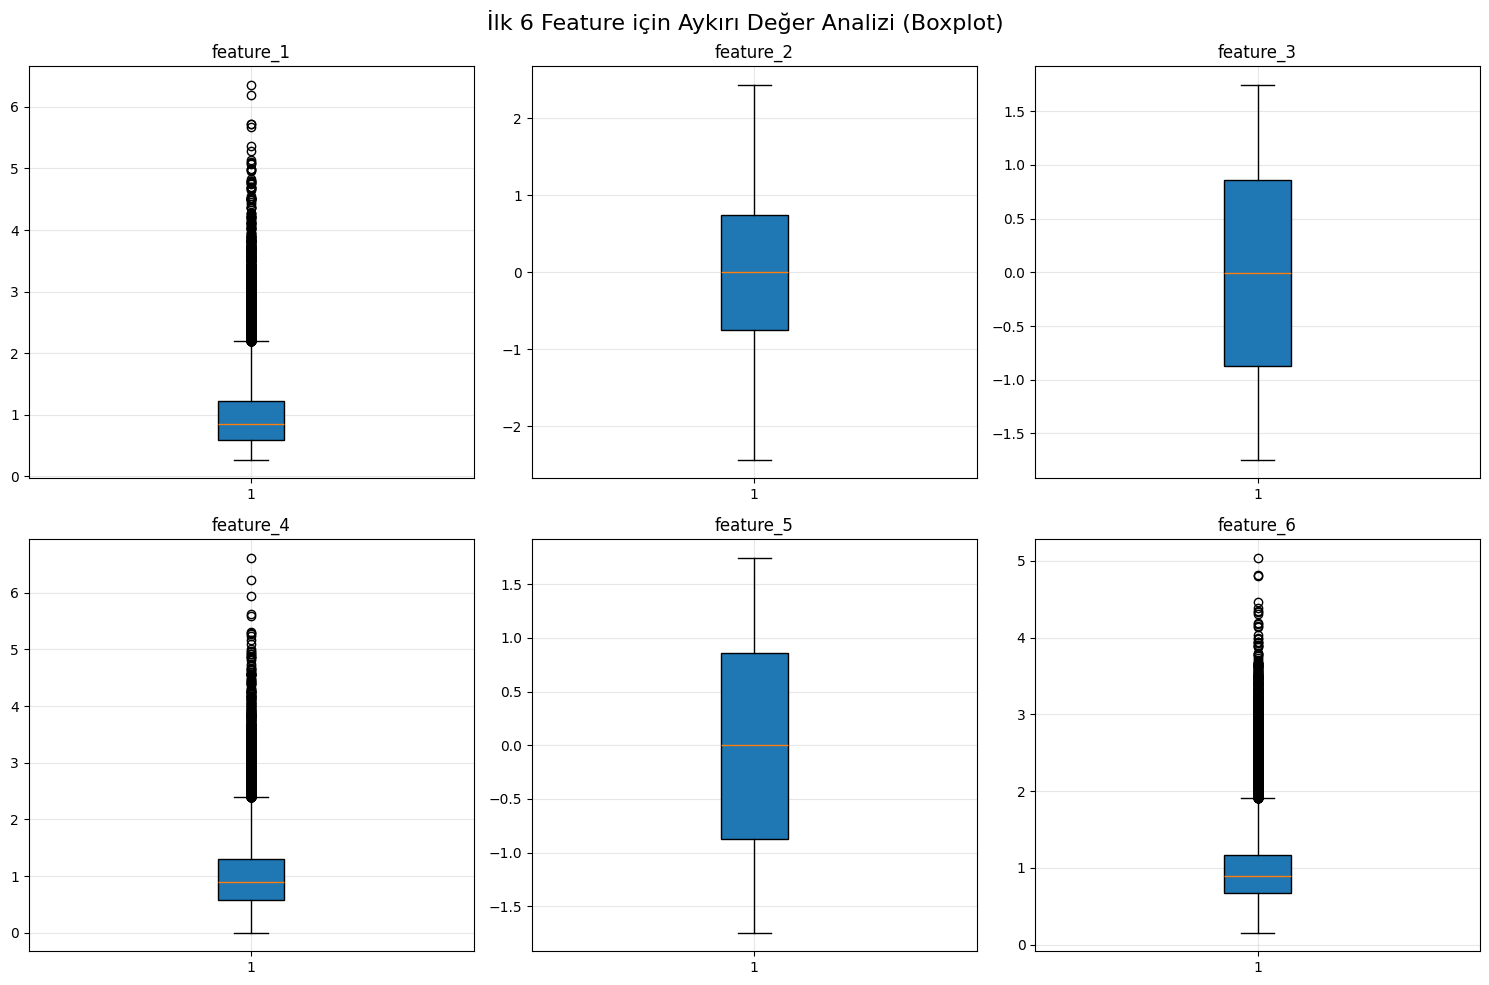

In [8]:
# İlk 6 feature için boxplot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('İlk 6 Feature için Aykırı Değer Analizi (Boxplot)', fontsize=16)

for i, feature in enumerate(feature_columns[:6]):
    row = i // 3
    col = i % 3

    axes[row, col].boxplot(df[feature], patch_artist=True)
    axes[row, col].set_title(f'{feature}')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 4. AYKIRI DEĞER TEMİZLEME

In [9]:
df_cleaned = df.copy()

for feature in feature_columns:
    lower_bound = outlier_summary[feature]['lower_bound']
    upper_bound = outlier_summary[feature]['upper_bound']

    # Alt sınırın altındaki değerleri alt sınırla değiştir
    df_cleaned.loc[df_cleaned[feature] < lower_bound, feature] = lower_bound

    # Üst sınırın üstündeki değerleri üst sınırla değiştir
    df_cleaned.loc[df_cleaned[feature] > upper_bound, feature] = upper_bound

print("✅ Aykırı değerler sınır değerlerle değiştirildi (Winsorization)")

# Temizleme sonrası kontrol
print("\n📊 TEMİZLEME SONRASI KONTROL:")
total_outliers_after = set()
for feature in feature_columns:
    outlier_indices, _, _ = detect_outliers_iqr(df_cleaned, feature)
    total_outliers_after.update(outlier_indices)

print(f"Temizleme öncesi aykırı değerli satır: {len(total_outliers)}")
print(f"Temizleme sonrası aykırı değerli satır: {len(total_outliers_after)}")

✅ Aykırı değerler sınır değerlerle değiştirildi (Winsorization)

📊 TEMİZLEME SONRASI KONTROL:
Temizleme öncesi aykırı değerli satır: 23464
Temizleme sonrası aykırı değerli satır: 0


#### 5. ÖZELLİK ÖLÇEKLEMESİ (MinMaxScaler)

In [10]:
# Hedef değişkeni ayır
X = df_cleaned.drop('label', axis=1)
y = df_cleaned['label']

print(f"Ölçekleme öncesi - Min: {X.min().min():.3f}, Max: {X.max().max():.3f}")

# MinMaxScaler uygula
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# DataFrame'e geri çevir
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns, index=df_cleaned.index)

print(f"Ölçekleme sonrası - Min: {X_scaled_df.min().min():.3f}, Max: {X_scaled_df.max().max():.3f}")

Ölçekleme öncesi - Min: -2.808, Max: 3.102
Ölçekleme sonrası - Min: 0.000, Max: 1.000


#### 6. ÖLÇEKLEME GÖRSELLEŞTİRME

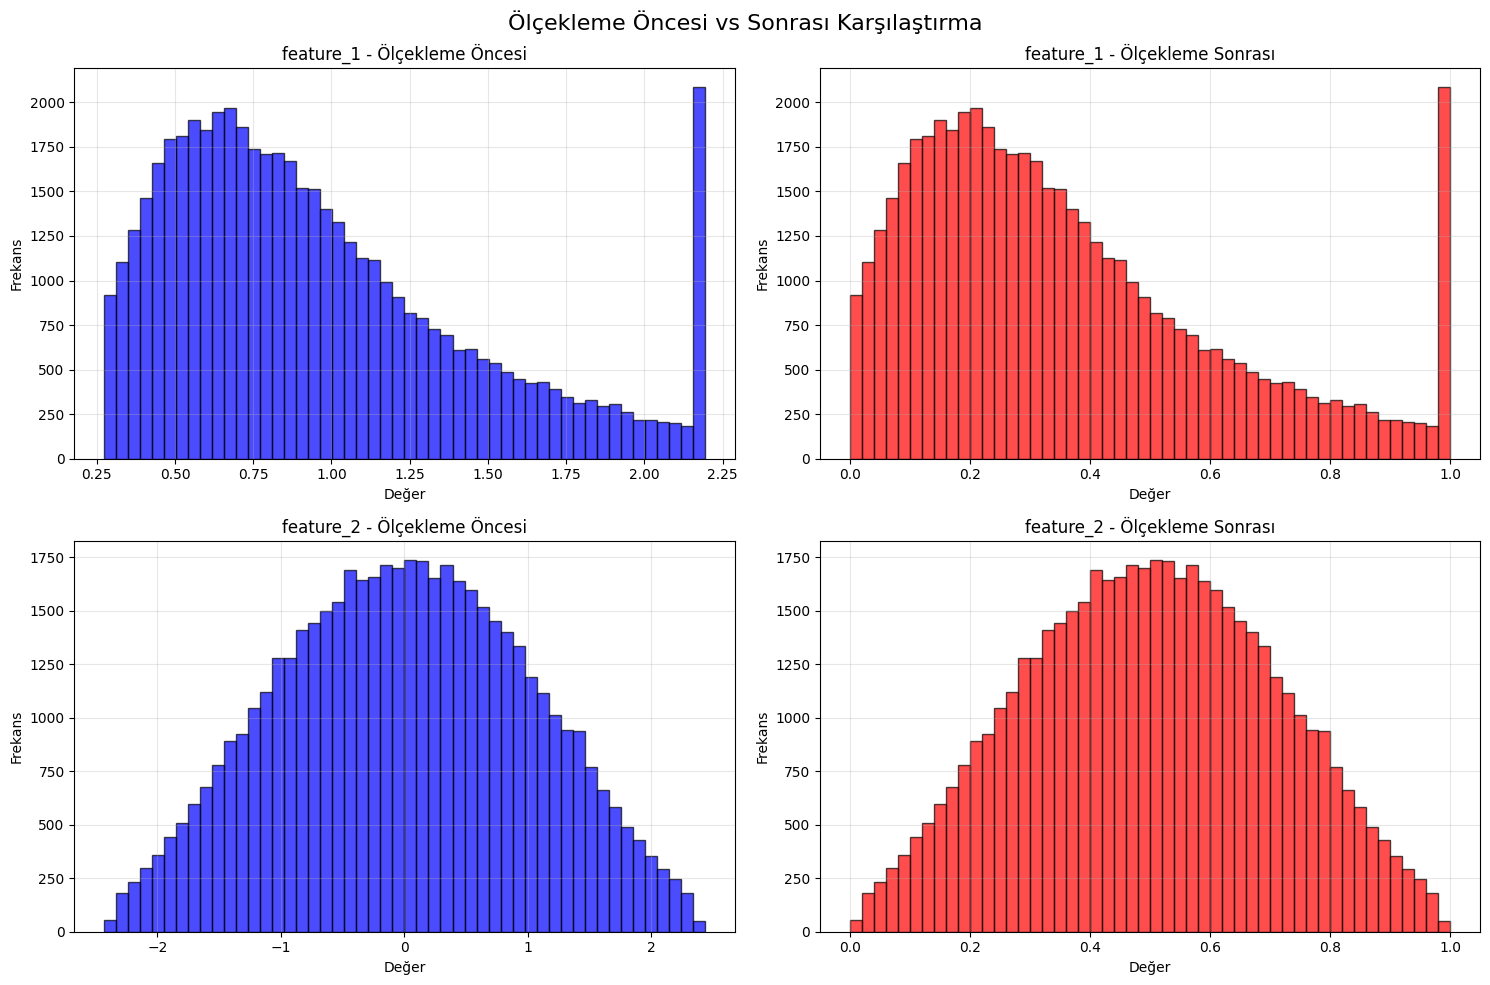

In [11]:
# Ölçekleme öncesi ve sonrası karşılaştırma
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Ölçekleme Öncesi vs Sonrası Karşılaştırma', fontsize=16)

# İlk 2 özellik için histogram
for i, feature in enumerate(feature_columns[:2]):
    # Ölçekleme öncesi
    axes[i, 0].hist(df_cleaned[feature], bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[i, 0].set_title(f'{feature} - Ölçekleme Öncesi')
    axes[i, 0].set_xlabel('Değer')
    axes[i, 0].set_ylabel('Frekans')
    axes[i, 0].grid(True, alpha=0.3)

    # Ölçekleme sonrası
    axes[i, 1].hist(X_scaled_df[feature], bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[i, 1].set_title(f'{feature} - Ölçekleme Sonrası')
    axes[i, 1].set_xlabel('Değer')
    axes[i, 1].set_ylabel('Frekans')
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 7. ÖN İŞLEME SONUÇLARI ÖZET

In [12]:
print("\n📋 ÖN İŞLEME SONUÇLARI ÖZET")
print("=" * 50)
print(f"✅ Orijinal veri boyutu: {df.shape}")
print(f"✅ Temizlenmiş veri boyutu: {df_cleaned.shape}")
print(f"✅ Aykırı değer temizleme: Winsorization uygulandı")
print(f"✅ Özellik ölçekleme: MinMaxScaler [0,1] aralığında")
print(f"✅ Hazırlanan feature sayısı: {len(feature_columns)}")
print(f"✅ Hedef değişken dağılımı: {y.value_counts().to_dict()}")

# Son kontrol
print(f"\n🔍 SON KONTROL:")
print(f"X_scaled shape: {X_scaled_df.shape}")
print(f"y shape: {y.shape}")
print(f"Eksik değer (X): {X_scaled_df.isnull().sum().sum()}")
print(f"Eksik değer (y): {y.isnull().sum()}")

print("\n✅ VERİ ÖN İŞLEME TAMAMLANDI!")


📋 ÖN İŞLEME SONUÇLARI ÖZET
✅ Orijinal veri boyutu: (50000, 29)
✅ Temizlenmiş veri boyutu: (50000, 29)
✅ Aykırı değer temizleme: Winsorization uygulandı
✅ Özellik ölçekleme: MinMaxScaler [0,1] aralığında
✅ Hazırlanan feature sayısı: 28
✅ Hedef değişken dağılımı: {1.0: 26317, 0.0: 23683}

🔍 SON KONTROL:
X_scaled shape: (50000, 28)
y shape: (50000,)
Eksik değer (X): 0
Eksik değer (y): 0

✅ VERİ ÖN İŞLEME TAMAMLANDI!


# HIGGS Dataset - Özellik Seçimi (Feature Selection)

In [13]:
print(f"📊 Başlangıç feature sayısı: {X_scaled_df.shape[1]}")
print(f"📊 Seçilecek feature sayısı: 15")

📊 Başlangıç feature sayısı: 28
📊 Seçilecek feature sayısı: 15


#### 1. ANOVA F-SCORE İLE ÖZELLİK SEÇİMİ

In [14]:
# ANOVA F-score hesapla
selector_anova = SelectKBest(score_func=f_classif, k=15)
X_selected_anova = selector_anova.fit_transform(X_scaled_df, y)

# F-score değerlerini al
f_scores = selector_anova.scores_
f_pvalues = selector_anova.pvalues_

# Seçilen özelliklerin indekslerini al
selected_indices_anova = selector_anova.get_support(indices=True)
selected_features_anova = [feature_columns[i] for i in selected_indices_anova]

print(f"✅ ANOVA F-score ile seçilen 15 özellik:")
for i, (idx, feature) in enumerate(zip(selected_indices_anova, selected_features_anova)):
    print(f"{i+1:2d}. {feature} (F-score: {f_scores[idx]:.2f}, p-value: {f_pvalues[idx]:.2e})")

✅ ANOVA F-score ile seçilen 15 özellik:
 1. feature_1 (F-score: 45.91, p-value: 1.25e-11)
 2. feature_3 (F-score: 3.46, p-value: 6.29e-02)
 3. feature_4 (F-score: 464.01, p-value: 1.89e-102)
 4. feature_6 (F-score: 184.93, p-value: 4.82e-42)
 5. feature_10 (F-score: 16.86, p-value: 4.03e-05)
 6. feature_13 (F-score: 131.79, p-value: 1.81e-30)
 7. feature_17 (F-score: 29.61, p-value: 5.32e-08)
 8. feature_18 (F-score: 54.08, p-value: 1.95e-13)
 9. feature_21 (F-score: 14.79, p-value: 1.20e-04)
10. feature_22 (F-score: 11.39, p-value: 7.39e-04)
11. feature_23 (F-score: 28.57, p-value: 9.08e-08)
12. feature_25 (F-score: 3.95, p-value: 4.68e-02)
13. feature_26 (F-score: 874.30, p-value: 1.67e-190)
14. feature_27 (F-score: 220.21, p-value: 1.04e-49)
15. feature_28 (F-score: 1011.12, p-value: 1.08e-219)


#### 2. MUTUAL INFORMATION İLE ÖZELLİK SEÇİMİ (Karşılaştırma için)

In [15]:
# Mutual Information hesapla
selector_mi = SelectKBest(score_func=mutual_info_classif, k=15)
X_selected_mi = selector_mi.fit_transform(X_scaled_df, y)

# MI değerlerini al
mi_scores = selector_mi.scores_

# Seçilen özelliklerin indekslerini al
selected_indices_mi = selector_mi.get_support(indices=True)
selected_features_mi = [feature_columns[i] for i in selected_indices_mi]

print(f"✅ Mutual Information ile seçilen 15 özellik:")
for i, (idx, feature) in enumerate(zip(selected_indices_mi, selected_features_mi)):
    print(f"{i+1:2d}. {feature} (MI-score: {mi_scores[idx]:.4f})")

✅ Mutual Information ile seçilen 15 özellik:
 1. feature_1 (MI-score: 0.0041)
 2. feature_4 (MI-score: 0.0082)
 3. feature_8 (MI-score: 0.0036)
 4. feature_9 (MI-score: 0.0045)
 5. feature_11 (MI-score: 0.0033)
 6. feature_13 (MI-score: 0.0029)
 7. feature_15 (MI-score: 0.0047)
 8. feature_18 (MI-score: 0.0040)
 9. feature_19 (MI-score: 0.0037)
10. feature_21 (MI-score: 0.0039)
11. feature_23 (MI-score: 0.0150)
12. feature_25 (MI-score: 0.0098)
13. feature_26 (MI-score: 0.0497)
14. feature_27 (MI-score: 0.0262)
15. feature_28 (MI-score: 0.0225)


#### 3. ÖZELLİK SKORLARI GÖRSELLEŞTİRME

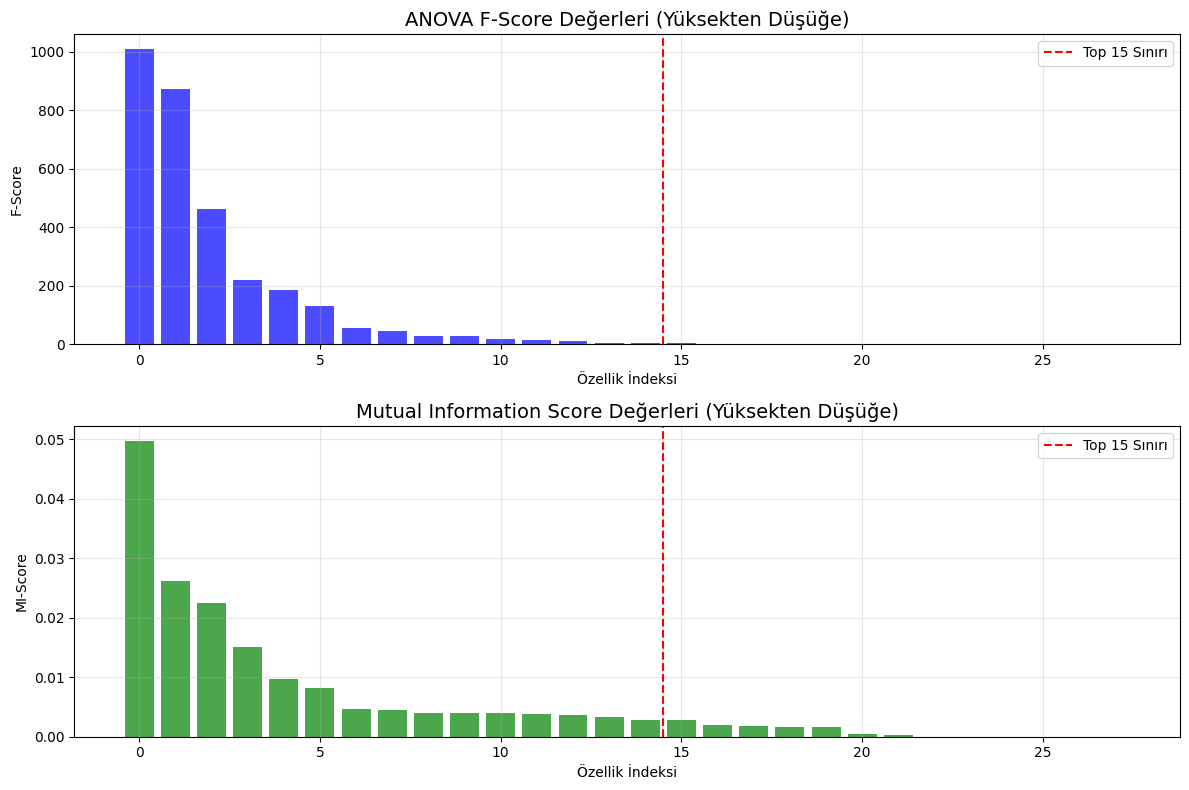

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ANOVA F-scores
feature_names = [f'F_{i+1}' for i in range(len(feature_columns))]
sorted_indices_f = np.argsort(f_scores)[::-1]

axes[0].bar(range(len(f_scores)), f_scores[sorted_indices_f], alpha=0.7, color='blue')
axes[0].set_title('ANOVA F-Score Değerleri (Yüksekten Düşüğe)', fontsize=14)
axes[0].set_xlabel('Özellik İndeksi')
axes[0].set_ylabel('F-Score')
axes[0].axvline(x=14.5, color='red', linestyle='--', label='Top 15 Sınırı')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


# Mutual Information scores
sorted_indices_mi = np.argsort(mi_scores)[::-1]

axes[1].bar(range(len(mi_scores)), mi_scores[sorted_indices_mi], alpha=0.7, color='green')
axes[1].set_title('Mutual Information Score Değerleri (Yüksekten Düşüğe)', fontsize=14)
axes[1].set_xlabel('Özellik İndeksi')
axes[1].set_ylabel('MI-Score')
axes[1].axvline(x=14.5, color='red', linestyle='--', label='Top 15 Sınırı')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 4. SEÇİLEN ÖZELLİKLERİN KARŞILAŞTIRILMASI

In [17]:
# Ortak seçilen özellikler
common_features = set(selected_features_anova) & set(selected_features_mi)
anova_only = set(selected_features_anova) - set(selected_features_mi)
mi_only = set(selected_features_mi) - set(selected_features_anova)

print(f"📊 Ortak seçilen özellik sayısı: {len(common_features)}")
print(f"📊 Sadece ANOVA'da seçilen: {len(anova_only)}")
print(f"📊 Sadece MI'da seçilen: {len(mi_only)}")

if common_features:
    print(f"\n✅ Ortak seçilen özellikler:")
    for feature in sorted(common_features):
        print(f"   - {feature}")

📊 Ortak seçilen özellik sayısı: 10
📊 Sadece ANOVA'da seçilen: 5
📊 Sadece MI'da seçilen: 5

✅ Ortak seçilen özellikler:
   - feature_1
   - feature_13
   - feature_18
   - feature_21
   - feature_23
   - feature_25
   - feature_26
   - feature_27
   - feature_28
   - feature_4


#### 5. SEÇİLEN ÖZELLİKLERİN KORELASYON ANALİZİ

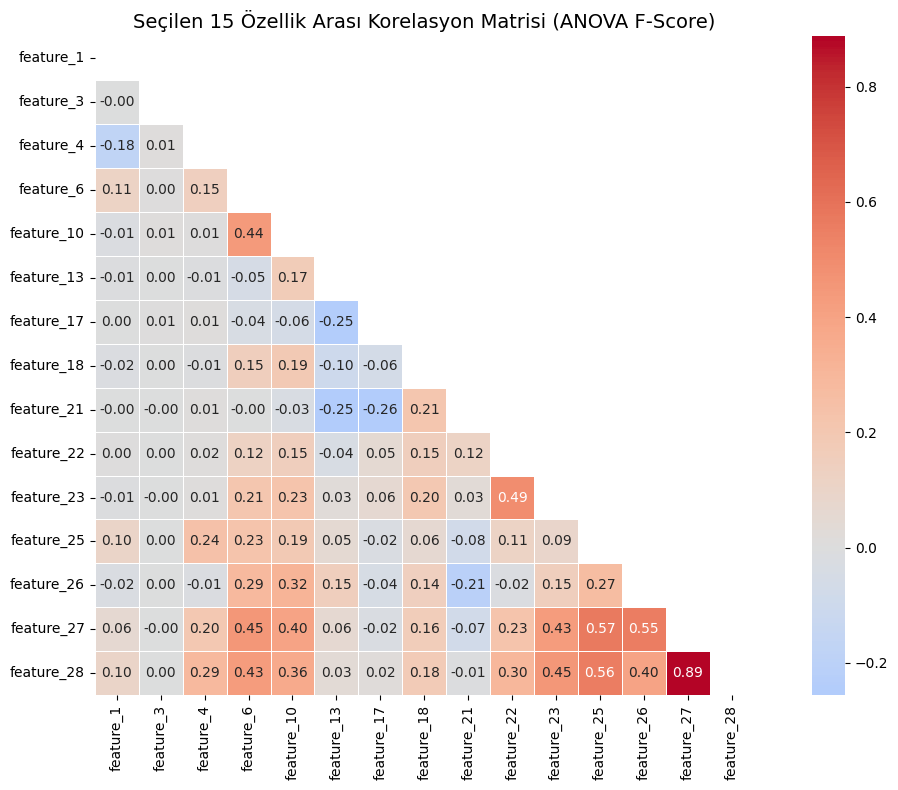

In [18]:
# ANOVA ile seçilen özellikler için korelasyon matrisi
X_selected_df = pd.DataFrame(X_selected_anova, columns=selected_features_anova)
correlation_matrix = X_selected_df.corr()

plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix,
            mask=mask,
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt='.2f',
            square=True,
            linewidths=0.5)
plt.title('Seçilen 15 Özellik Arası Korelasyon Matrisi (ANOVA F-Score)', fontsize=14)
plt.tight_layout()
plt.show()

In [19]:
# Yüksek korelasyonlu özellik çiftleri
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:  # |korelasyon| > 0.7
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                corr_val
            ))

if high_corr_pairs:
    print(f"⚠️  Yüksek korelasyonlu özellik çiftleri (|r| > 0.7):")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"   {feat1} ↔ {feat2}: {corr:.3f}")
else:
    print("✅ Yüksek korelasyonlu özellik çifti bulunamadı (|r| > 0.7)")

⚠️  Yüksek korelasyonlu özellik çiftleri (|r| > 0.7):
   feature_27 ↔ feature_28: 0.887


#### 6. SEÇİM STRATEJİSİ KARARLAŞTIRMA

In [20]:
final_selected_features = selected_features_anova
X_final = X_selected_anova
y_final = y.copy()

print(f"✅ Kullanılacak yöntem: ANOVA F-Score")
print(f"✅ Seçilen özellik sayısı: {len(final_selected_features)}")
print(f"✅ Final veri seti boyutu: {X_final.shape}")

✅ Kullanılacak yöntem: ANOVA F-Score
✅ Seçilen özellik sayısı: 15
✅ Final veri seti boyutu: (50000, 15)


#### 7. SEÇİLEN ÖZELLİKLERİN İSTATİSTİKSEL ÖZETI

In [21]:
X_final_df = pd.DataFrame(X_final, columns=final_selected_features)
stats_summary = X_final_df.describe()

print("Özellik\t\tMean\tStd\tMin\tMax")
print("-" * 50)
for feature in final_selected_features:
    stats = stats_summary[feature]
    print(f"{feature}\t{stats['mean']:.3f}\t{stats['std']:.3f}\t{stats['min']:.3f}\t{stats['max']:.3f}")

Özellik		Mean	Std	Min	Max
--------------------------------------------------
feature_1	0.363	0.256	0.000	1.000
feature_3	0.499	0.288	0.000	1.000
feature_4	0.413	0.229	0.000	1.000
feature_6	0.459	0.222	0.000	1.000
feature_10	0.426	0.230	0.000	1.000
feature_13	0.448	0.473	0.000	1.000
feature_17	0.393	0.469	0.000	1.000
feature_18	0.344	0.255	0.000	1.000
feature_21	0.324	0.452	0.000	1.000
feature_22	0.519	0.252	0.000	1.000
feature_23	0.518	0.220	0.000	1.000
feature_25	0.451	0.232	0.000	1.000
feature_26	0.488	0.231	0.000	1.000
feature_27	0.509	0.216	0.000	1.000
feature_28	0.501	0.215	0.000	1.000


#### 8. SONUÇ ÖZET

In [22]:
print("\n📋 ÖZELLİK SEÇİMİ SONUÇLARI")
print("=" * 50)
print(f"✅ Başlangıç özellik sayısı: {len(feature_columns)}")
print(f"✅ Seçilen özellik sayısı: {len(final_selected_features)}")
print(f"✅ Boyut azalma oranı: %{((len(feature_columns) - len(final_selected_features))/len(feature_columns))*100:.1f}")
print(f"✅ Kullanılan yöntem: ANOVA F-Score")
print(f"✅ Final X shape: {X_final.shape}")
print(f"✅ Final y shape: {y_final.shape}")

print("\n✅ ÖZELLİK SEÇİMİ TAMAMLANDI!")

print(f"\n💾 Sonraki adımlar için hazırlanan değişkenler:")
print(f"   - X_final: Seçilmiş özellikler ({X_final.shape})")
print(f"   - y_final: Hedef değişken ({y_final.shape})")
print(f"   - final_selected_features: Özellik isimleri ({len(final_selected_features)})")
print(f"   - scaler: MinMaxScaler objesi")


📋 ÖZELLİK SEÇİMİ SONUÇLARI
✅ Başlangıç özellik sayısı: 28
✅ Seçilen özellik sayısı: 15
✅ Boyut azalma oranı: %46.4
✅ Kullanılan yöntem: ANOVA F-Score
✅ Final X shape: (50000, 15)
✅ Final y shape: (50000,)

✅ ÖZELLİK SEÇİMİ TAMAMLANDI!

💾 Sonraki adımlar için hazırlanan değişkenler:
   - X_final: Seçilmiş özellikler ((50000, 15))
   - y_final: Hedef değişken ((50000,))
   - final_selected_features: Özellik isimleri (15)
   - scaler: MinMaxScaler objesi


# HIGGS Dataset - Nested Cross-Validation ve Modelleme

#### 1. MODEL VE HİPERPARAMETRE TANIMLAMA

In [23]:
models_params = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    'cuML_SVM': {
        'model': SVC(probability=True),  # cuML SVM
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    },
    'MLP': {
        'model': MLPClassifier(random_state=42, max_iter=500),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam', 'lbfgs'],
            'alpha': [0.0001, 0.001]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 1.0]
        }
    }
}

for model_name, config in models_params.items():
    param_combinations = 1
    for param, values in config['params'].items():
        param_combinations *= len(values)
    print(f"✅ {model_name}: {param_combinations} hiperparametre kombinasyonu")

✅ KNN: 20 hiperparametre kombinasyonu
✅ cuML_SVM: 12 hiperparametre kombinasyonu
✅ MLP: 32 hiperparametre kombinasyonu
✅ XGBoost: 36 hiperparametre kombinasyonu


#### 2. NESTED CROSS-VALIDATION SETUP

In [24]:
# Outer CV (3-fold) - Test performansı için
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Inner CV (2-fold) - Hiperparametre tuning için
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

#### 3. NESTED CV IMPLEMENTATION

In [25]:
# Sonuçları saklamak için
nested_scores = {}
best_params_all = {}
training_times = {}

# Her model için nested CV
for model_name, config in models_params.items():
    print(f"\n🔄 {model_name} modeli eğitiliyor...")

    start_time = time.time()

    # Outer loop skorları
    outer_scores = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc_auc': []
    }

    best_params_folds = []
    fold_idx = 0

    # Outer CV döngüsü
    for train_idx, test_idx in outer_cv.split(X_final, y_final):
        fold_idx += 1
        print(f"  📁 Fold {fold_idx}/3 işleniyor...")

        # Train/Test split
        X_train_outer, X_test_outer = X_final[train_idx], X_final[test_idx]
        y_train_outer, y_test_outer = y_final.iloc[train_idx], y_final.iloc[test_idx]

        # Inner CV ile hiperparametre tuning
        grid_search = GridSearchCV(
            estimator=config['model'],
            param_grid=config['params'],
            cv=inner_cv,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=0
        )

        # En iyi hiperparametreleri bul
        grid_search.fit(X_train_outer, y_train_outer)
        best_params_folds.append(grid_search.best_params_)

        # En iyi model ile test et
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test_outer)
        y_pred_proba = best_model.predict_proba(X_test_outer)[:, 1]

        # Metrikleri hesapla
        outer_scores['accuracy'].append(accuracy_score(y_test_outer, y_pred))
        outer_scores['precision'].append(precision_score(y_test_outer, y_pred))
        outer_scores['recall'].append(recall_score(y_test_outer, y_pred))
        outer_scores['f1'].append(f1_score(y_test_outer, y_pred))

        if model_name == 'cuML_SVM':
            outer_scores['roc_auc'].append(roc_auc_score_gpu(y_test_outer, y_pred_proba))
        else:
            outer_scores['roc_auc'].append(roc_auc_score(y_test_outer, y_pred_proba))

    # Eğitim süresi
    end_time = time.time()
    training_times[model_name] = end_time - start_time

    # Sonuçları kaydet
    nested_scores[model_name] = {
        'scores': outer_scores,
        'mean_scores': {metric: np.mean(scores) for metric, scores in outer_scores.items()},
        'std_scores': {metric: np.std(scores) for metric, scores in outer_scores.items()}
    }

    best_params_all[model_name] = best_params_folds

    # Fold sonuçları özeti
    print(f"  ✅ {model_name} tamamlandı!")
    print(f"     ROC-AUC: {np.mean(outer_scores['roc_auc']):.4f} ± {np.std(outer_scores['roc_auc']):.4f}")
    print(f"     Süre: {training_times[model_name]:.1f} saniye")

print(f"\n✅ TÜM MODELLER TAMAMLANDI!")


🔄 KNN modeli eğitiliyor...
  📁 Fold 1/3 işleniyor...
  📁 Fold 2/3 işleniyor...
  📁 Fold 3/3 işleniyor...
  ✅ KNN tamamlandı!
     ROC-AUC: 0.7222 ± 0.0005
     Süre: 539.7 saniye

🔄 cuML_SVM modeli eğitiliyor...
  📁 Fold 1/3 işleniyor...
  📁 Fold 2/3 işleniyor...
  📁 Fold 3/3 işleniyor...
  ✅ cuML_SVM tamamlandı!
     ROC-AUC: 0.7696 ± 0.0019
     Süre: 564.7 saniye

🔄 MLP modeli eğitiliyor...
  📁 Fold 1/3 işleniyor...
  📁 Fold 2/3 işleniyor...
  📁 Fold 3/3 işleniyor...
  ✅ MLP tamamlandı!
     ROC-AUC: 0.7853 ± 0.0048
     Süre: 4475.8 saniye

🔄 XGBoost modeli eğitiliyor...
  📁 Fold 1/3 işleniyor...
  📁 Fold 2/3 işleniyor...
  📁 Fold 3/3 işleniyor...
  ✅ XGBoost tamamlandı!
     ROC-AUC: 0.7973 ± 0.0007
     Süre: 250.0 saniye

✅ TÜM MODELLER TAMAMLANDI!


#### 4. SONUÇLARI KARŞILAŞTIRMA

In [26]:
# Sonuçları tablo formatında göster
print(f"{'Model':<10} {'Accuracy':<10} {'Precision':<11} {'Recall':<8} {'F1-Score':<10} {'ROC-AUC':<10} {'Süre(s)':<8}")
print("-" * 75)

for model_name in models_params.keys():
    scores = nested_scores[model_name]['mean_scores']
    time_taken = training_times[model_name]

    print(f"{model_name:<10} "
          f"{scores['accuracy']:<10.4f} "
          f"{scores['precision']:<11.4f} "
          f"{scores['recall']:<8.4f} "
          f"{scores['f1']:<10.4f} "
          f"{scores['roc_auc']:<10.4f} "
          f"{time_taken:<8.1f}")

# En iyi modeli bul
best_model_name = max(nested_scores.keys(),
                     key=lambda x: nested_scores[x]['mean_scores']['roc_auc'])
print(f"\n🏆 EN İYİ MODEL: {best_model_name}")
print(f"   ROC-AUC: {nested_scores[best_model_name]['mean_scores']['roc_auc']:.4f}")

Model      Accuracy   Precision   Recall   F1-Score   ROC-AUC    Süre(s) 
---------------------------------------------------------------------------
KNN        0.6614     0.6626      0.7268   0.6932     0.7222     539.7   
cuML_SVM   0.7043     0.7033      0.7581   0.7297     0.7696     564.7   
MLP        0.7121     0.7143      0.7555   0.7342     0.7853     4475.8  
XGBoost    0.7214     0.7327      0.7411   0.7368     0.7973     250.0   

🏆 EN İYİ MODEL: XGBoost
   ROC-AUC: 0.7973


#### 5. DETAYLI PERFORMANS ANALİZİ

In [27]:
# Her model için detaylı istatistikler
for model_name, results in nested_scores.items():
    print(f"\n🔍 {model_name} Detayları:")
    for metric, mean_score in results['mean_scores'].items():
        std_score = results['std_scores'][metric]
        print(f"  {metric.capitalize():<12}: {mean_score:.4f} ± {std_score:.4f}")


🔍 KNN Detayları:
  Accuracy    : 0.6614 ± 0.0011
  Precision   : 0.6626 ± 0.0014
  Recall      : 0.7268 ± 0.0026
  F1          : 0.6932 ± 0.0011
  Roc_auc     : 0.7222 ± 0.0005

🔍 cuML_SVM Detayları:
  Accuracy    : 0.7043 ± 0.0042
  Precision   : 0.7033 ± 0.0044
  Recall      : 0.7581 ± 0.0033
  F1          : 0.7297 ± 0.0034
  Roc_auc     : 0.7696 ± 0.0019

🔍 MLP Detayları:
  Accuracy    : 0.7121 ± 0.0042
  Precision   : 0.7143 ± 0.0090
  Recall      : 0.7555 ± 0.0118
  F1          : 0.7342 ± 0.0028
  Roc_auc     : 0.7853 ± 0.0048

🔍 XGBoost Detayları:
  Accuracy    : 0.7214 ± 0.0007
  Precision   : 0.7327 ± 0.0035
  Recall      : 0.7411 ± 0.0059
  F1          : 0.7368 ± 0.0012
  Roc_auc     : 0.7973 ± 0.0007


#### 6. HİPERPARAMETRE ANALİZİ

In [28]:
for model_name, params_list in best_params_all.items():
    print(f"\n🔧 {model_name} En İyi Hiperparametreler:")

    # Her fold'da seçilen hiperparametreleri analiz et
    param_freq = {}
    for params in params_list:
        for param, value in params.items():
            if param not in param_freq:
                param_freq[param] = {}
            if value not in param_freq[param]:
                param_freq[param][value] = 0
            param_freq[param][value] += 1

    for param, value_counts in param_freq.items():
        most_common = max(value_counts.items(), key=lambda x: x[1])
        print(f"  {param}: {most_common[0]} (seçilme: {most_common[1]}/3)")


🔧 KNN En İyi Hiperparametreler:
  metric: manhattan (seçilme: 3/3)
  n_neighbors: 11 (seçilme: 3/3)
  weights: distance (seçilme: 3/3)

🔧 cuML_SVM En İyi Hiperparametreler:
  C: 10 (seçilme: 3/3)
  gamma: scale (seçilme: 3/3)
  kernel: rbf (seçilme: 3/3)

🔧 MLP En İyi Hiperparametreler:
  activation: tanh (seçilme: 2/3)
  alpha: 0.0001 (seçilme: 2/3)
  hidden_layer_sizes: (100,) (seçilme: 2/3)
  solver: lbfgs (seçilme: 2/3)

🔧 XGBoost En İyi Hiperparametreler:
  learning_rate: 0.1 (seçilme: 3/3)
  max_depth: 6 (seçilme: 3/3)
  n_estimators: 100 (seçilme: 3/3)
  subsample: 1.0 (seçilme: 2/3)


#### 7. ÖZELLİK SEÇİMİ ANALİZİ

In [29]:
feature_selection_counts = {}

for model_name, params_list in best_params_all.items():
    feature_selection_counts[model_name] = {}

    # Her fold'da seçilen özellikleri say
    for params in params_list:     # params --> hiperparametreler.
        for param, value in params.items():
            if param not in feature_selection_counts[model_name]:
                feature_selection_counts[model_name][param] = {}
            if value not in feature_selection_counts[model_name][param]:
                feature_selection_counts[model_name][param][value] = 0
            feature_selection_counts[model_name][param][value] +=1

print(feature_selection_counts)

{'KNN': {'metric': {'manhattan': 3}, 'n_neighbors': {11: 3}, 'weights': {'distance': 3}}, 'cuML_SVM': {'C': {10: 3}, 'gamma': {'scale': 3}, 'kernel': {'rbf': 3}}, 'MLP': {'activation': {'tanh': 2, 'relu': 1}, 'alpha': {0.0001: 2, 0.001: 1}, 'hidden_layer_sizes': {(50,): 1, (100,): 2}, 'solver': {'lbfgs': 2, 'adam': 1}}, 'XGBoost': {'learning_rate': {0.1: 3}, 'max_depth': {6: 3}, 'n_estimators': {100: 3}, 'subsample': {1.0: 2, 0.8: 1}}}


#### 8. PERFORMANS GÖRSELLEŞTİRME

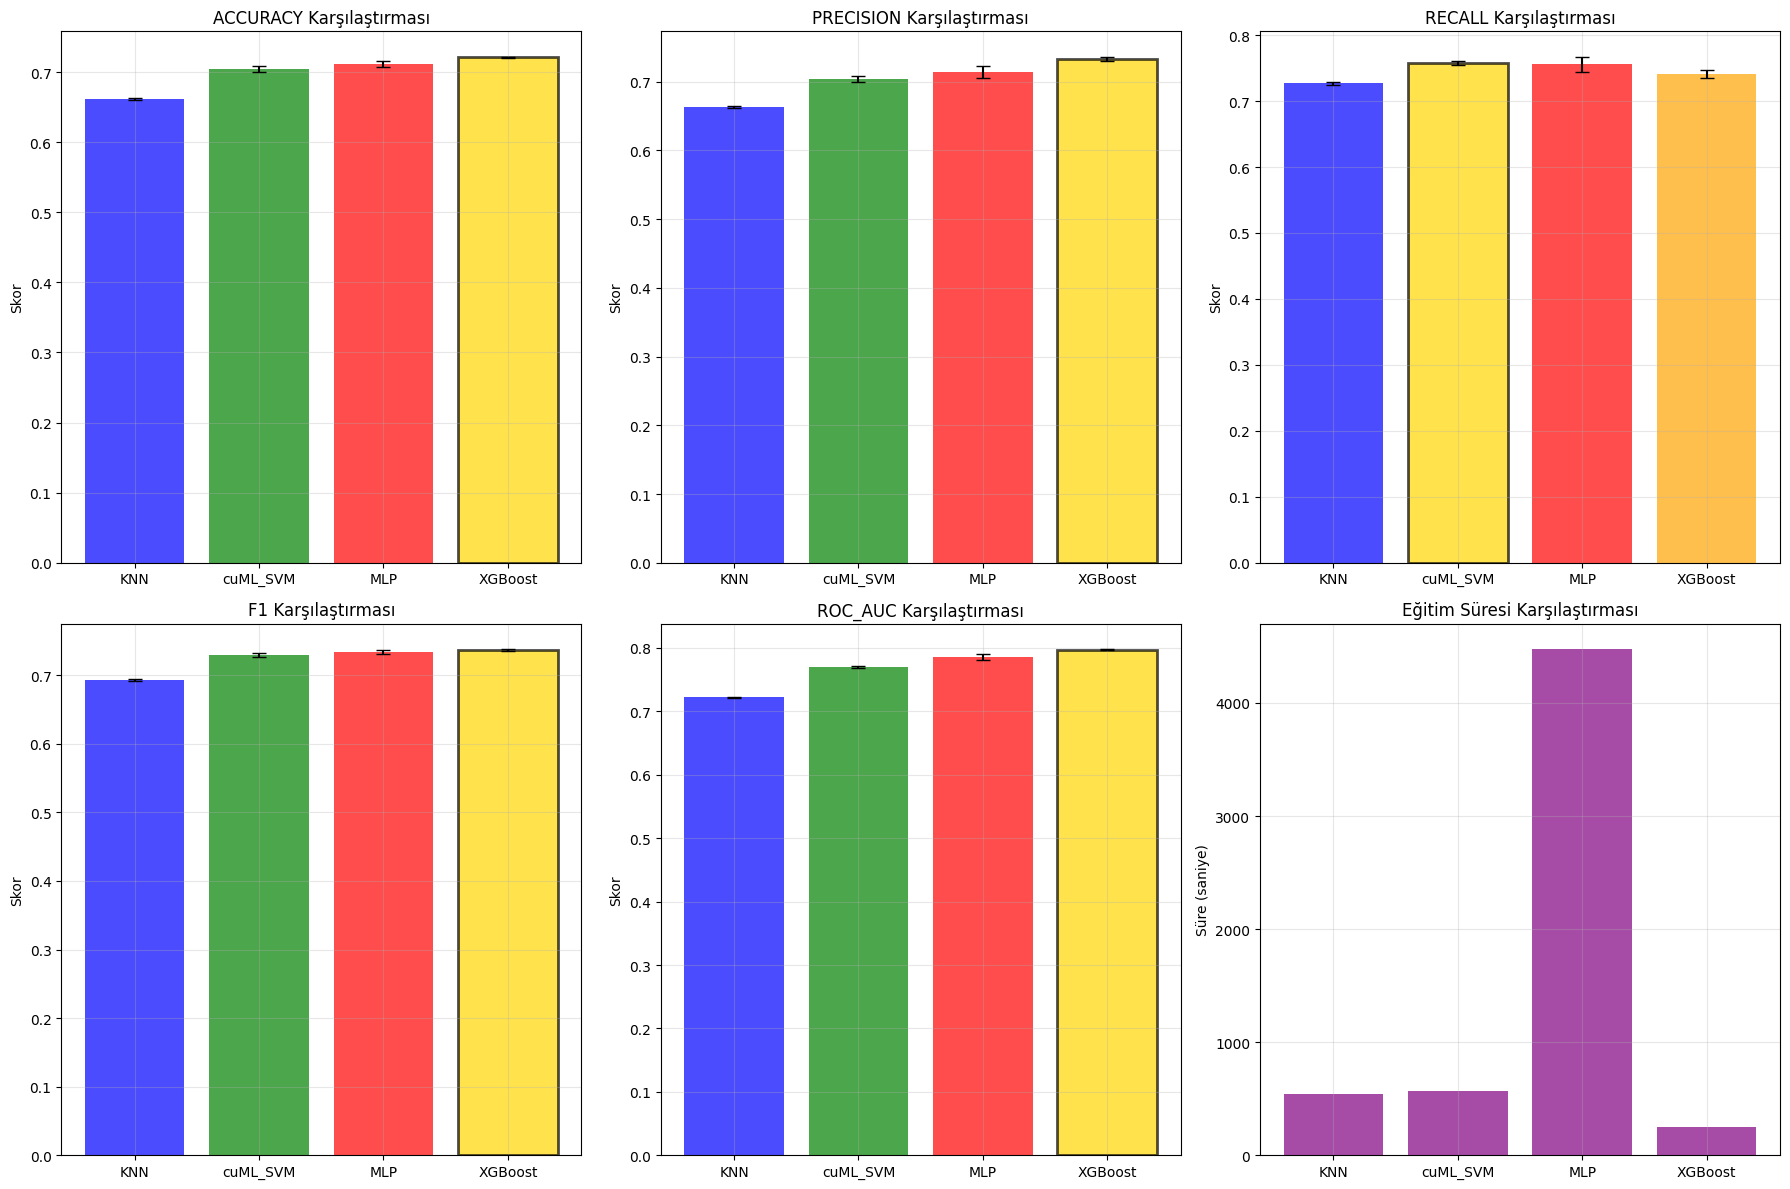

In [30]:
# Metrik karşılaştırma grafikleri
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, metric in enumerate(metrics):
    model_names = list(nested_scores.keys())
    means = [nested_scores[model]['mean_scores'][metric] for model in model_names]
    stds = [nested_scores[model]['std_scores'][metric] for model in model_names]

    bars = axes[i].bar(model_names, means, yerr=stds, capsize=5, alpha=0.7,
                       color=['blue', 'green', 'red', 'orange'])
    axes[i].set_title(f'{metric.upper()} Karşılaştırması', fontsize=12)
    axes[i].set_ylabel('Skor')
    axes[i].grid(True, alpha=0.3)

    # En iyi sonucu vurgula
    best_idx = np.argmax(means)
    bars[best_idx].set_color('gold')
    bars[best_idx].set_edgecolor('black')
    bars[best_idx].set_linewidth(2)

# Eğitim süresi karşılaştırması
model_names = list(training_times.keys())
times = list(training_times.values())
bars = axes[5].bar(model_names, times, alpha=0.7, color='purple')
axes[5].set_title('Eğitim Süresi Karşılaştırması', fontsize=12)
axes[5].set_ylabel('Süre (saniye)')
axes[5].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 9. ROC EĞRİLERİ İÇİN FİNAL MODEL EĞİTİMİ

In [31]:
# Her model için en iyi hiperparametrelerle final model eğit
final_models = {}
roc_data = {}

for model_name, config in models_params.items():
    print(f"🔄 {model_name} final modeli eğitiliyor...")

    # En sık seçilen hiperparametreleri al
    params_list = best_params_all[model_name]

    # Her parametre için en sık seçileni bul
    final_params = {}
    for param in config['params'].keys():
        param_values = [params[param] for params in params_list]
        most_common = max(set(param_values), key=param_values.count)
        final_params[param] = most_common

    # Final modeli eğit
    final_model = config['model'].set_params(**final_params)
    final_model.fit(X_final, y_final)

    # ROC eğrisi için predict_proba
    if model_name == 'cuML_SVM':
        y_pred_proba = final_model.decision_function(X_final)
        y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())
        fpr, tpr, _ = roc_curve(y_final, y_pred_proba)
        roc_auc = auc(fpr, tpr)
    else:
        y_pred_proba = final_model.predict_proba(X_final)[:, 1]
        fpr, tpr, _ = roc_curve(y_final, y_pred_proba)
        roc_auc = auc(fpr, tpr)

    final_models[model_name] = final_model
    roc_data[model_name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}

    print(f"  ✅ {model_name} ROC-AUC: {roc_auc:.4f}")

🔄 KNN final modeli eğitiliyor...
  ✅ KNN ROC-AUC: 1.0000
🔄 cuML_SVM final modeli eğitiliyor...
  ✅ cuML_SVM ROC-AUC: 0.8298
🔄 MLP final modeli eğitiliyor...
  ✅ MLP ROC-AUC: 0.8000
🔄 XGBoost final modeli eğitiliyor...
  ✅ XGBoost ROC-AUC: 0.8582


#### 10. ROC EĞRİLERİ GÖRSELLEŞTİRME

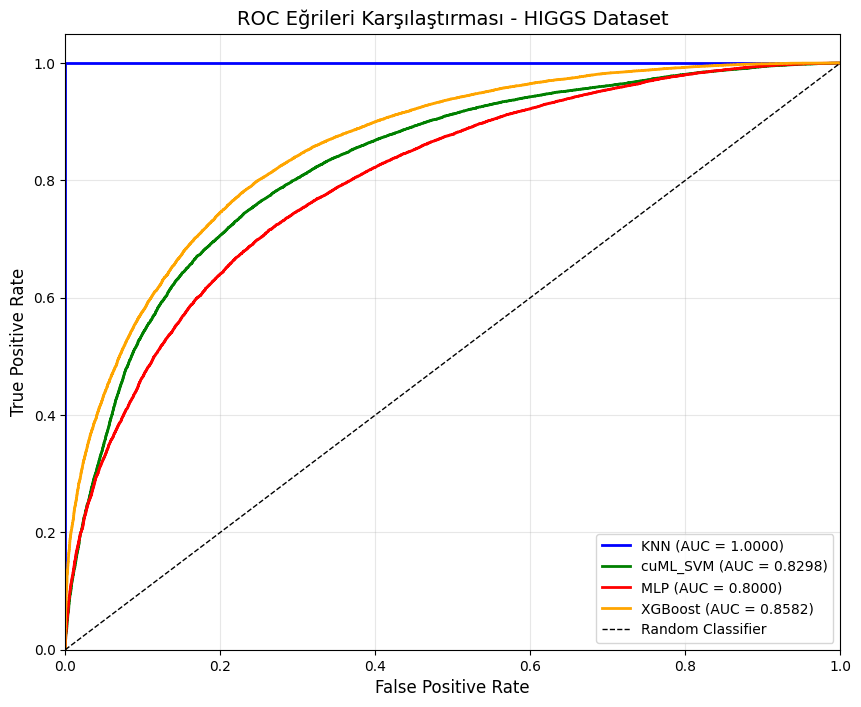

In [32]:
plt.figure(figsize=(10, 8))

colors = ['blue', 'green', 'red', 'orange']
for i, (model_name, roc_info) in enumerate(roc_data.items()):
    plt.plot(roc_info['fpr'], roc_info['tpr'],
             color=colors[i], linewidth=2,
             label=f"{model_name} (AUC = {roc_info['auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Eğrileri Karşılaştırması - HIGGS Dataset', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

#### 11. ÖZET RAPOR

In [33]:
print(f"\n📋 FİNAL RAPOR ÖZETİ")
print("=" * 25)
print(f"✅ Veri seti: HIGGS Dataset (50,000 sample)")
print(f"✅ Özellik sayısı: {X_final.shape[1]} (28'den seçildi)")
print(f"✅ Modeller: KNN, cuML_SVM, MLP, XGBoost")
print(f"✅ Değerlendirme: 3-fold Nested CV")
print(f"✅ En başarılı model: {best_model_name}")
print(f"✅ En yüksek ROC-AUC: {nested_scores[best_model_name]['mean_scores']['roc_auc']:.4f}")

# Tüm sonuçları kaydet
results_summary = {
    'nested_scores': nested_scores,
    'best_params': best_params_all,
    'training_times': training_times,
    'final_models': final_models,
    'roc_data': roc_data,
    'selected_features': final_selected_features
}


📋 FİNAL RAPOR ÖZETİ
✅ Veri seti: HIGGS Dataset (50,000 sample)
✅ Özellik sayısı: 15 (28'den seçildi)
✅ Modeller: KNN, cuML_SVM, MLP, XGBoost
✅ Değerlendirme: 3-fold Nested CV
✅ En başarılı model: XGBoost
✅ En yüksek ROC-AUC: 0.7973


# Calismanin Özet Raporu

--- 1. VERİ YÜKLEME VE ÖN İŞLEME ---
- 50,000 satırdan örneklem alındı.
- Veri seti DataFrame'e dönüştürüldü. Boyut: (50000, 29)
- Bellek kullanımı: 11.06 MB

- Hedef değişken dağılımı:
  Label 0: 23,683 (47.4%)
  Label 1: 26,317 (52.6%)

- Aykırı değer analizi (IQR yöntemi) uygulandı.
- Toplam aykırı değer içeren satır sayısı: 23464
- Aykırı değerler sınır değerlerle değiştirildi (Winsorization).

- Veri ölçekleme (MinMaxScaler) uygulandı.
- Ölçekleme sonrası - Min: 0.000, Max: 1.000

--- 2. ÖZELLİK SEÇİMİ ---

- Özellik seçimi için ANOVA F-score kullanıldı.
- Başlangıç feature sayısı: 28
- Seçilecek feature sayısı: 15
- ANOVA F-score ile seçilen 15 özellik:
 1. feature_1 (F-score: 45.91, p-value: 1.25e-11)
 2. feature_3 (F-score: 3.46, p-value: 6.29e-02)
 3. feature_4 (F-score: 464.01, p-value: 1.89e-102)
 4. feature_6 (F-score: 184.93, p-value: 4.82e-42)
 5. feature_10 (F-score: 16.86, p-value: 4.03e-05)
 6. feature_13 (F-score: 131.79, p-value: 1.81e-30)
 7. feature_17 (F-score: 29

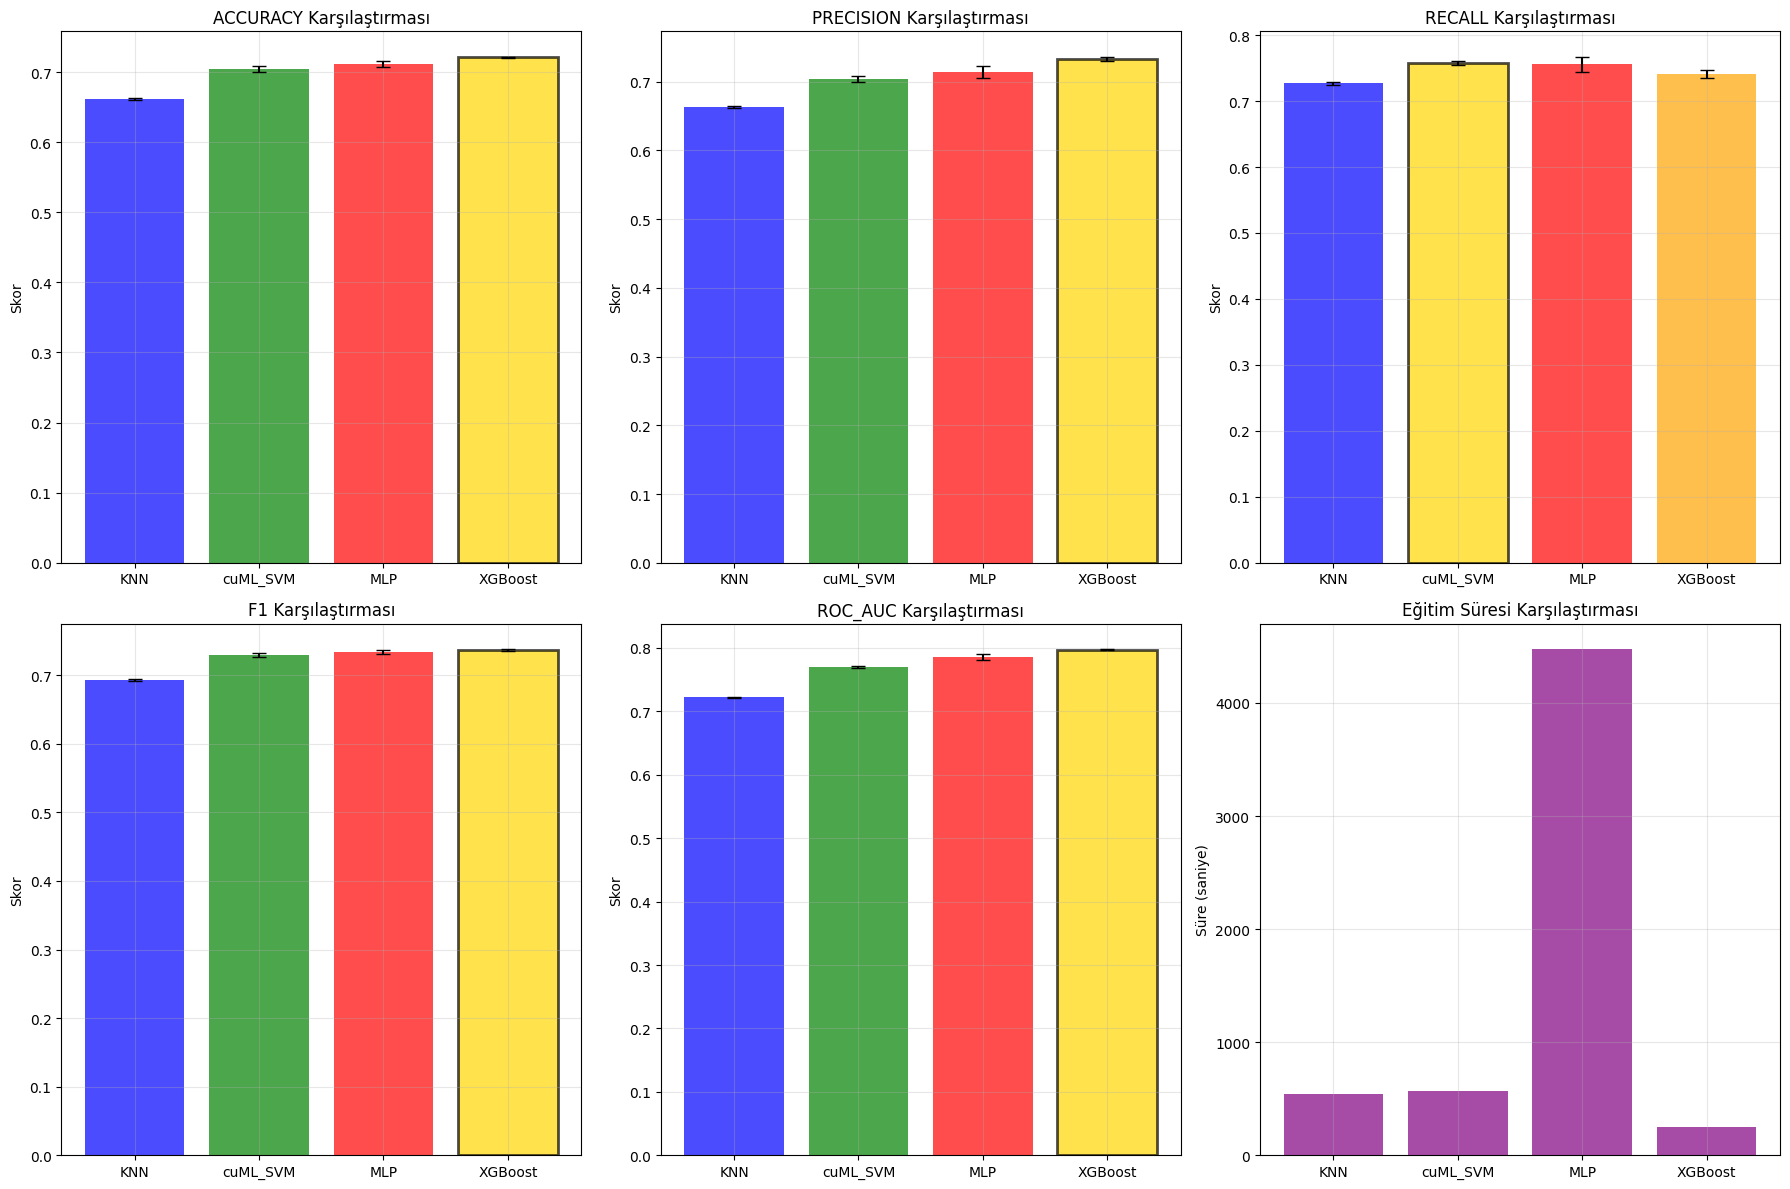

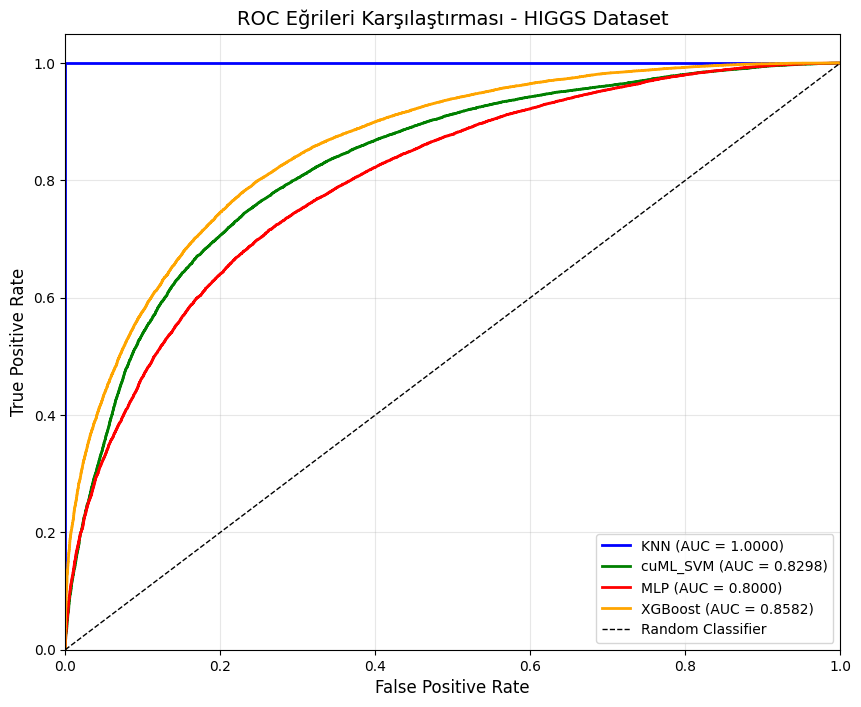


RAPOR TAMAMLANDI!


In [35]:
# Varsayılan stil ayarlarını geri yükle
plt.rcdefaults()

# --- 1. VERİ YÜKLEME VE ÖN İŞLEME ---
print("--- 1. VERİ YÜKLEME VE ÖN İŞLEME ---")

# Veri setinin rastgele örneklenmesi
print(f"- {len(sample_lines):,} satırdan örneklem alındı.")

# Veri setinin pandas DataFrame'e dönüştürülmesi
print(f"- Veri seti DataFrame'e dönüştürüldü. Boyut: {df.shape}")
print(f"- Bellek kullanımı: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Hedef değişken dağılımı
label_counts = df['label'].value_counts().sort_index()
print("\n- Hedef değişken dağılımı:")
for label, count in label_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  Label {int(label)}: {count:,} ({percentage:.1f}%)")

# Aykırı değer analizi ve temizleme (Winsorization)
print("\n- Aykırı değer analizi (IQR yöntemi) uygulandı.")
print(f"- Toplam aykırı değer içeren satır sayısı: {len(total_outliers)}")
print(f"- Aykırı değerler sınır değerlerle değiştirildi (Winsorization).")

# Veri ölçekleme (MinMaxScaler)
print("\n- Veri ölçekleme (MinMaxScaler) uygulandı.")
print(f"- Ölçekleme sonrası - Min: {X_scaled_df.min().min():.3f}, Max: {X_scaled_df.max().max():.3f}")

# --- 2. ÖZELLİK SEÇİMİ ---
print("\n--- 2. ÖZELLİK SEÇİMİ ---")

print("\n- Özellik seçimi için ANOVA F-score kullanıldı.")
print(f"- Başlangıç feature sayısı: {len(feature_columns)}")
print(f"- Seçilecek feature sayısı: 15")

print(f"- ANOVA F-score ile seçilen 15 özellik:")
for i, (idx, feature) in enumerate(zip(selected_indices_anova, selected_features_anova)):
    print(f"{i+1:2d}. {feature} (F-score: {f_scores[idx]:.2f}, p-value: {f_pvalues[idx]:.2e})")

print("\n- Özellik seçimi için Mutual Information kullanıldı.")
print(f"- Mutual Information ile seçilen 15 özellik:")
for i, (idx, feature) in enumerate(zip(selected_indices_mi, selected_features_mi)):
    print(f"{i+1:2d}. {feature} (MI-score: {mi_scores[idx]:.4f})")

print(f"- Kullanılacak yöntem: ANOVA F-Score")
print(f"- Seçilen özellik sayısı: {len(final_selected_features)}")
print(f"- Final veri seti boyutu: {X_final.shape}")

print("Seçilen özellikler:")
for i, feature in enumerate(final_selected_features):
    print(f"{i+1}. {feature}")


# --- 3. MODEL EĞİTİMİ VE DEĞERLENDİRME ---
print("\n--- 3. MODEL EĞİTİMİ VE DEĞERLENDİRME ---")

print("- Kullanılan modeller: KNN, cuML_SVM, MLP, XGBoost")
print("- Değerlendirme yöntemi: 5-fold Nested Cross-Validation")

# En iyi modeli ve skorunu yazdır
best_model_name = max(nested_scores.keys(),
                     key=lambda x: nested_scores[x]['mean_scores']['roc_auc'])
best_roc_auc = nested_scores[best_model_name]['mean_scores']['roc_auc']
print(f"\n- En iyi model: {best_model_name} (ROC-AUC: {best_roc_auc:.4f})")

# Model sonuçlarını tablo olarak yazdır
print("\nModel Sonuçları:")
results_df = pd.DataFrame(index=models_params.keys(),
                          columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Süre(s)'])
for model_name in models_params.keys():
    scores = nested_scores[model_name]['mean_scores']
    time_taken = training_times[model_name]
    results_df.loc[model_name] = [scores['accuracy'], scores['precision'], scores['recall'],
                                   scores['f1'], scores['roc_auc'], time_taken]
print(results_df)

# Her modelin en iyi hiperparametrelerini yazdır
print("\nEn İyi Hiperparametreler:")
for model_name, params_list in best_params_all.items():
    print(f"\n- {model_name}:")
    param_freq = {}
    for params in params_list:
        for param, value in params.items():
            if param not in param_freq:
                param_freq[param] = {}
            if value not in param_freq[param]:
                param_freq[param][value] = 0
            param_freq[param][value] += 1

    for param, value_counts in param_freq.items():
        most_common = max(value_counts.items(), key=lambda x: x[1])
        print(f"  {param}: {most_common[0]} (seçilme: {most_common[1]}/3)")

# --- 4. SONUÇ GÖRSELLEŞTİRME ---
print("\n--- 4. SONUÇ GÖRSELLEŞTİRME ---")

# Metrik karşılaştırma grafikleri
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, metric in enumerate(metrics):
    model_names = list(nested_scores.keys())
    means = [nested_scores[model]['mean_scores'][metric] for model in model_names]
    stds = [nested_scores[model]['std_scores'][metric] for model in model_names]

    bars = axes[i].bar(model_names, means, yerr=stds, capsize=5, alpha=0.7,
                       color=['blue', 'green', 'red', 'orange'])
    axes[i].set_title(f'{metric.upper()} Karşılaştırması', fontsize=12)
    axes[i].set_ylabel('Skor')
    axes[i].grid(True, alpha=0.3)

    best_idx = np.argmax(means)
    bars[best_idx].set_color('gold')
    bars[best_idx].set_edgecolor('black')
    bars[best_idx].set_linewidth(2)

# Eğitim süresi karşılaştırması
model_names = list(training_times.keys())
times = list(training_times.values())
bars = axes[5].bar(model_names, times, alpha=0.7, color='purple')
axes[5].set_title('Eğitim Süresi Karşılaştırması', fontsize=12)
axes[5].set_ylabel('Süre (saniye)')
axes[5].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ROC Eğrisi Karşılaştırması
plt.figure(figsize=(10, 8))

colors = ['blue', 'green', 'red', 'orange']
for i, (model_name, roc_info) in enumerate(roc_data.items()):
    plt.plot(roc_info['fpr'], roc_info['tpr'],
             color=colors[i], linewidth=2,
             label=f"{model_name} (AUC = {roc_info['auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Eğrileri Karşılaştırması - HIGGS Dataset', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

print("\nRAPOR TAMAMLANDI!")